# (04) LaplaceVAE

**Motivation**: Test rsample. Does it really work? <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vase/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'laplace'
from base.distributions import Laplace

## Plot some dists

In [3]:
mu = nn.Parameter(torch.tensor([0.0, 4.0, -3.0]))
log_scale = nn.Parameter(torch.tensor([0.0, 0.5, 0.0]))

In [4]:
dist = Laplace(mu, log_scale)
samples = dist.sample_n(1000)

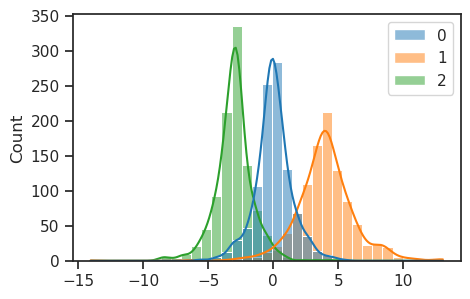

In [5]:
sns.histplot(tonp(samples.squeeze()), kde=True);

In [6]:
dist.loc

Parameter containing:
tensor([ 0.,  4., -3.], requires_grad=True)

In [7]:
dist.scale

tensor([1.0000, 1.6463, 1.0000], grad_fn=<ExpBackward0>)

## Test grads

In [8]:
mu = nn.Parameter(torch.tensor([0.0]), requires_grad=True)
log_scale = nn.Parameter(torch.tensor([0.0]), requires_grad=True)

In [9]:
tgt = torch.tensor([5])

In [10]:
optim = torch.optim.Adam([mu, log_scale])

In [11]:
%%time

losses = []
for i in range(int(2e5)):
    optim.zero_grad()
    
    dist = Laplace(mu, log_scale)
    z = dist.rsample()
    loss = (z - tgt).pow(2).sum()
    loss.backward()
    
    optim.step()

    losses.append(loss.item())

CPU times: user 1min 7s, sys: 553 ms, total: 1min 7s
Wall time: 1min 7s


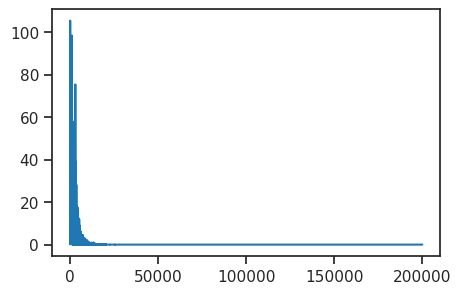

In [12]:
plt.plot(losses);

In [13]:
mu, log_scale

(Parameter containing:
 tensor([4.9995], requires_grad=True),
 Parameter containing:
 tensor([-37.1463], requires_grad=True))

In [14]:
dist = Laplace(mu, log_scale)
samples = dist.sample_n(10000)

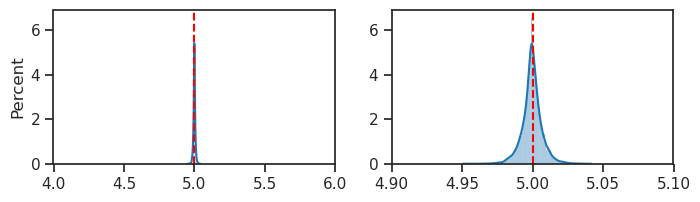

In [15]:
fig, axes = create_figure(1, 2, (8, 2))

for ax in axes.flat:
    sns.histplot(tonp(samples.squeeze()), kde=True, stat='percent', ax=ax)
    ax.axvline(tgt.item(), color='r', ls='--')
axes[0].set(xlim=(4, 6))
axes[1].set(xlim=(4.9, 5.1), ylabel='')
plt.show()

In [16]:
dist = Laplace(mu, log_scale, clamp=None)
samples = dist.sample_n(10000)
collections.Counter(tonp(samples.squeeze()))

Counter({4.9995112: 10000})

## Make a LaplaceVAE

In [17]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'conv+b|conv+b')
print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'MNIST', 'n_ch': 32, 'n_latents': 10, 'latent_act': None, 'fit_prior': False, 'enc_type': 'conv', 
'dec_type': 'conv', 'enc_bias': True, 'dec_bias': True}

Trainer:
{'temp_anneal_portion': 0.0, 'temp_anneal_type': 'lin', 'temp_start': 1.0, 'temp_stop': 1.0, 'lr': 0.003, 'epochs':
1200, 'batch_size': 200, 'warm_restart': 2, 'optimizer_kws': {'weight_decay': 0.0003}, 'grad_clip': 1000}

In [18]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
print(vae.cfg.name())

laplace_None_MNIST_z-10_k-32_<conv+b|conv+b>

In [19]:
x = torch.randn(123, 1, 28, 28)
dist = vae.infer(x)

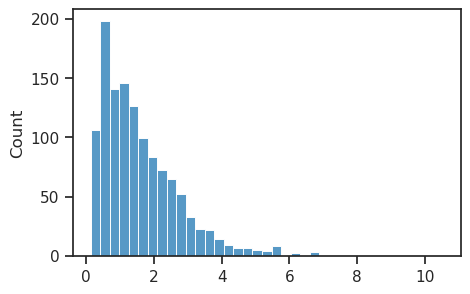

In [20]:
sns.histplot(tonp(dist.scale.ravel()));

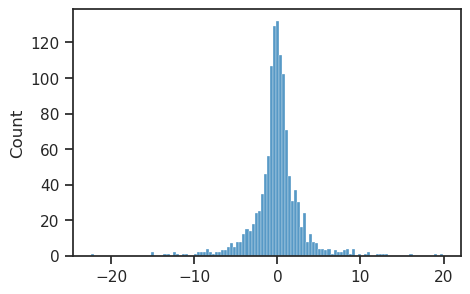

In [21]:
z = dist.rsample()
sns.histplot(tonp(z.ravel()));

In [22]:
vae.log_scale.requires_grad, vae.cfg.fit_prior

(False, False)

In [23]:
vae.Dist

base.distributions.Laplace

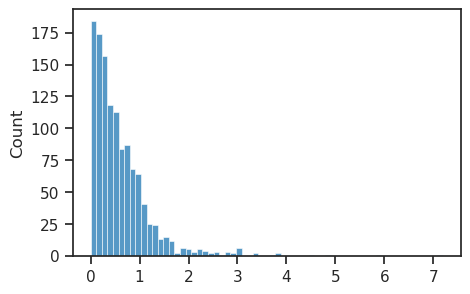

In [24]:
sns.histplot(tonp(dist.kl().ravel()));

In [25]:
np.unravel_index(torch.argmax(dist.kl()).item(), dist.loc.shape)

(54, 2)

In [26]:
dist.loc[54, 2], dist.scale[54, 2]

(tensor(-0.5620, grad_fn=<SelectBackward0>),
 tensor(10.5375, grad_fn=<SelectBackward0>))